1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [29]:
# !pip install scikit-uplift

In [31]:
# !pip install catboost

     |████████████████████████████████| 67.3MB 89kB/s 


In [186]:
# !pip install causalml

     |████████████████████████████████| 245kB 12.9MB/s 
     |████████████████████████████████| 20.1MB 5.7MB/s 
     |████████████████████████████████| 327kB 31.7MB/s 
     |████████████████████████████████| 1.8MB 43.4MB/s 
     |████████████████████████████████| 634kB 48.2MB/s 
  Created wheel for causalml: filename=causalml-0.10.0-cp37-cp37m-linux_x86_64.whl size=493704 sha256=9aaba3b7f887bc332b523dcadd9ff50aa00015258fb3de83e6fee44e553e012a
  Stored in directory: /root/.cache/pip/wheels/81/7f/44/c9d5ecf03f0d950f53302a5eab1c76bec07bcd5868753e22bf
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465031 sha256=3661e180a15f38470a48807f4553ce61fe95ed2236f8dc59b7a68026ad5013c9
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built causalml shap
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: datascience 0.10.6 has requiremen

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [99]:
# Чтение данных
df = pd.read_csv('data.csv')

#recency - месяцев с момента последней покупки
#history - стоимость исторических покупок
#used_discount - указывает, использовал ли покупатель скидку раньше
#used_bogo - казывает, использовал ли покупатель вариант "купить, получить, получить" раньше
#zip_code - класс почтового индекса как Пригородный / Городской / Сельский 
#is_referral - указывает, был ли клиент привлечен из реферального канала
#channel - каналы, которые использует клиент, Телефон / Интернет / Многоканальный
#offer - предложения, отправленные клиентам, Скидка / Но один - один / Нет предложения
#conversion - конверсия клиентов (покупать или нет)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [101]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [102]:
# Найдем уникальные значения
for col in df.select_dtypes(include=['object','int64']):
    print(df[col].unique())
    print('--'*20)

[10  6  7  9  2  1  5  4  3 11 12  8]
----------------------------------------
[1 0]
----------------------------------------
[0 1]
----------------------------------------
['Surburban' 'Rural' 'Urban']
----------------------------------------
[0 1]
----------------------------------------
['Phone' 'Web' 'Multichannel']
----------------------------------------
['Buy One Get One' 'No Offer' 'Discount']
----------------------------------------
[0 1]
----------------------------------------


In [103]:
# Сбалансированная ли выборка?
df['conversion'].value_counts()

0    54606
1     9394
Name: conversion, dtype: int64

In [104]:
# offer приводим к бинарному виду
df.loc[df['offer']=='Buy One Get One', 'offer'] = 1
df.loc[df['offer']=='Discount', 'offer'] = 1
df.loc[df['offer']=='No Offer', 'offer'] = 0
df['offer'].value_counts()

1    42694
0    21306
Name: offer, dtype: int64

In [105]:
# Переименовать поля (conversion -> target, offer -> treatment) 
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [106]:
from sklearn.model_selection import train_test_split
indices_learn, indices_valid = train_test_split(df.index, test_size=0.3, random_state=123)

In [108]:
cat_features = ['zip_code', 'channel']

In [162]:
X_train = df.loc[indices_learn, :].drop(columns=['treatment', 'target'])
y_train = df.loc[indices_learn, 'target']
treat_train = df.loc[indices_learn, 'treatment']

X_val = df.loc[indices_valid, :].drop(columns=['treatment', 'target'])
y_val = df.loc[indices_valid, 'target']
treat_val =  df.loc[indices_valid, 'treatment']

models_results = {
    'approach': [],
    'uplift@30%': [],
    'uplift@10%': []
}

In [110]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

In [163]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
#models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
#sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
#sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
# plot_uplift_preds(trmnt_preds=sm.trmnt_preds_, ctrl_preds=sm.ctrl_preds_);
models_results

{'approach': ['SoloModel'],
 'uplift@10%': [0.08925430023455824],
 'uplift@30%': [0.08116579350200559]}

In [164]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)

#models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score)

models_results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


{'approach': ['SoloModel', 'ClassTransformation'],
 'uplift@10%': [0.08925430023455824, 0.1174110633307271],
 'uplift@30%': [0.08116579350200559, 0.08118152701321804]}

In [165]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)

#models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score)

#plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);
models_results

{'approach': ['SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@10%': [0.08925430023455824, 0.1174110633307271, 0.07830580531665363],
 'uplift@30%': [0.08116579350200559, 0.08118152701321804, 0.07411785864742258]}

In [168]:
table_result=pd.DataFrame({'approach': models_results['approach'], 'uplift@10%':models_results['uplift@10%'],'uplift@30%': models_results['uplift@30%'] })

In [169]:
# Таблица с рез-ми
table_result

,approach,uplift@10%,uplift@30%
0,SoloModel,0.089254,0.081166
1,ClassTransformation,0.117411,0.081182
2,TwoModels,0.078306,0.074118


In [181]:
X_train

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
53181,8,121.56,0,1,Surburban,0,Web
42635,9,617.62,0,1,Urban,1,Phone
6296,5,185.62,1,0,Rural,1,Web
41722,1,359.03,0,1,Rural,0,Web
32660,10,139.68,1,0,Urban,0,Web
...,...,...,...,...,...,...,...
61404,1,172.98,1,0,Surburban,0,Web
17730,9,95.41,0,1,Surburban,0,Phone
28030,1,547.69,1,1,Rural,1,Multichannel
15725,5,341.39,0,1,Surburban,0,Phone


In [183]:
X_train_tree=pd.get_dummies(X_train, prefix=['zip_code', 'channel'])
X_train_tree.head(3)

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
53181,8,121.56,0,1,0,0,1,0,0,0,1
42635,9,617.62,0,1,1,0,0,1,0,1,0
6296,5,185.62,1,0,1,1,0,0,0,0,1


In [184]:
features = [col for col in X_train_tree]
features

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'is_referral',
 'zip_code_Rural',
 'zip_code_Surburban',
 'zip_code_Urban',
 'channel_Multichannel',
 'channel_Phone',
 'channel_Web']

In [190]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)

CPU times: user 2.21 s, sys: 22.9 ms, total: 2.24 s
Wall time: 2.25 s


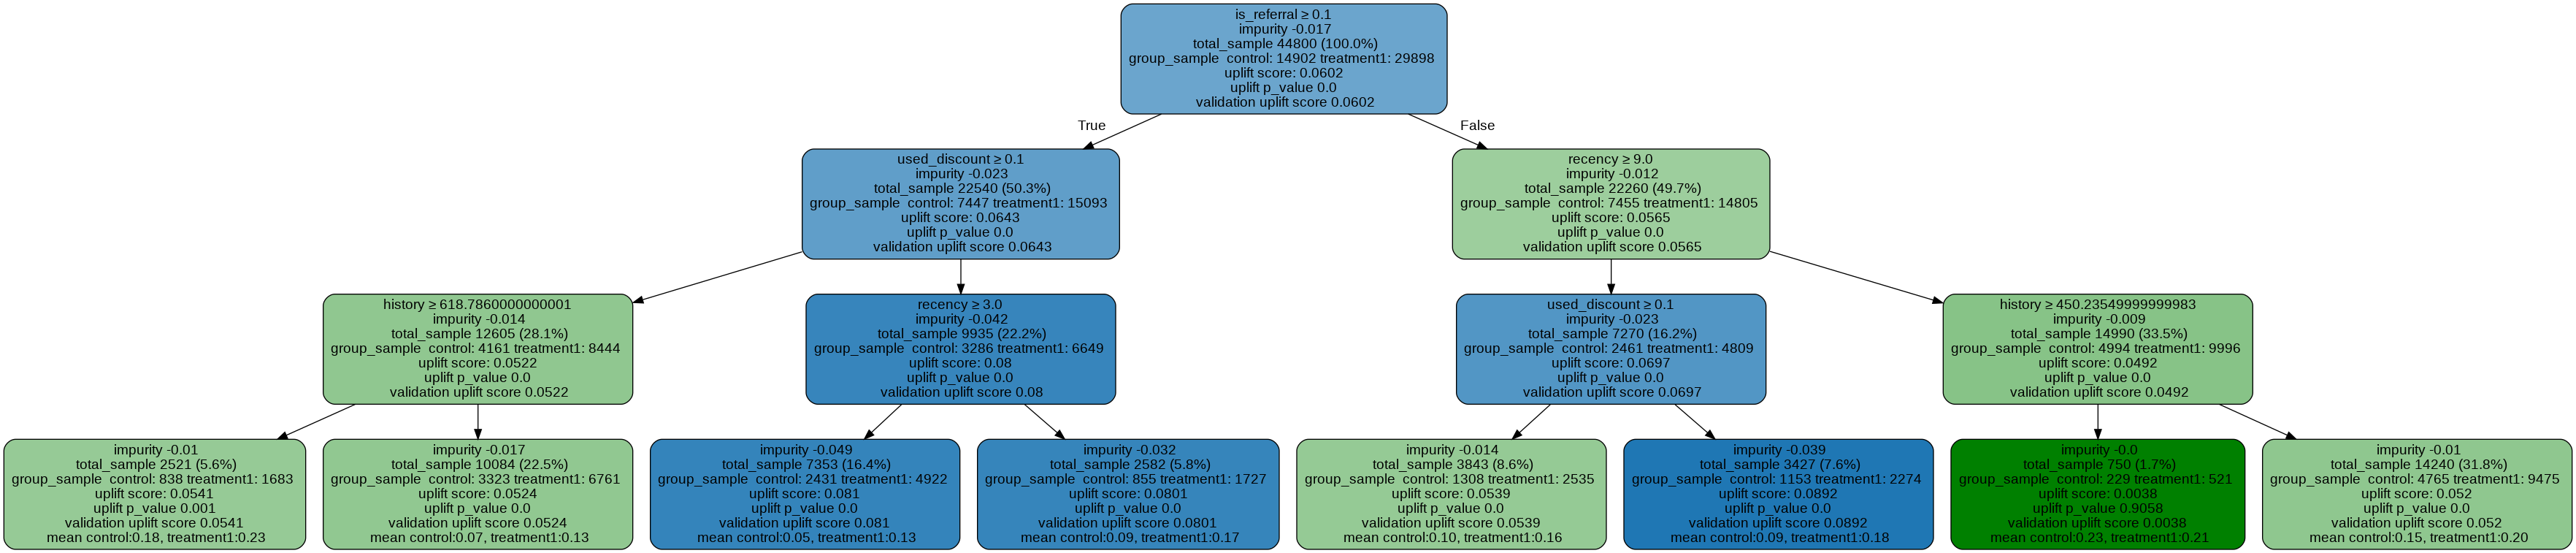

In [191]:
Image(graph.create_png())

На самом верхнем уровне было деление по "реферальному типу". Те кто пришел по "рефиральке" и ранее не пользовались скидкой С большей вероютностью совершат покупку, если им позовонить (знаяение uplite p_value близко к нулю) и не важно когда была совершенна покупка. При это те кто пользовался скидкой ранее, но давно ничего не покупал, так же могут что то купить, если им позовнить (вероятность правда меньше чем в вареанте выше) 

В соучае же, если клиент пришел не по рефиралке. при этом последняя покупка была больше 9 мес. назад тоже после звонка может сделать покупку! при этом с большей вероятностью, если он ранее пользовался скидкой.

